In [12]:
from pnet import pnet_loader, Pnet
from util import util, sankey_diag

import torch
import seaborn as sns
import pandas as pd
import numpy as np
import random
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import torch.nn.functional as F
import torch.nn as nn
import os
import scipy

%load_ext autoreload
%autoreload 2

In [2]:
datapath='/mnt/disks/pancan/data/'
#datapath='../data/'

In [3]:
directories = [datapath + x for x in os.listdir(datapath) if 'tcga_pan_can_atlas' in x]
#directories = ['../data/' + x for x in os.listdir('../data/') if 'tcga_pan_can_atlas' in x]

In [4]:
def load_single_dataset(directory_path):
    rna_exp = pd.read_csv(directory_path + '/data_mrna_seq_v2_rsem.txt',
                           sep='\t').dropna().set_index('Hugo_Symbol').drop(['Entrez_Gene_Id'], axis=1).T
    rna_exp = rna_exp.loc[:,~rna_exp.columns.duplicated()].astype(float).copy()
    cna = pd.read_csv(directory_path + '/data_cna.txt',
                      sep='\t').dropna().set_index('Hugo_Symbol').drop(['Entrez_Gene_Id'], axis=1).T
    cna.drop('Cytoband', errors='ignore', inplace=True)
    cna = cna.loc[:,~cna.columns.duplicated()].astype(float).copy()
    
    genes = list(set(rna_exp.columns).intersection(cna.columns))
    indices = list(set(rna_exp.index).intersection(cna.index))
    tumor_type = pd.DataFrame(len(indices)*[directory_path.split('/')[-1].split('_')[0]],
                              index = indices, columns=['tumor'])
    return rna_exp[genes], cna[genes], tumor_type

In [5]:
# For All data sets
rna, cna, tumor = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for path in directories:
    rna_, cna_, tumor_ = load_single_dataset(path)
    rna = pd.concat([rna_, rna])
    cna = pd.concat([cna_, cna])
    tumor = pd.concat([tumor_, tumor])
    
rna.dropna(axis=1, inplace=True)
cna.dropna(axis=1, inplace=True)
rna = (rna-rna.mean())/rna.std()

In [6]:
# For MESO data only
# rna, cna, tumor = util.load_tcga_dataset(directories[19], load_mut=False)

### External validation dataset

In [7]:
rna_ext_val = pd.read_csv('/mnt/disks/pancan/data/mel_dfci_2019/data_RNA_Seq_expression_tpm_all_sample_Zscores.txt',
                          delimiter='\t').set_index('Hugo_Symbol').T.drop('Entrez_Gene_Id').dropna(axis=1)
cna_ext_val = pd.read_csv('/mnt/disks/pancan/data/mel_dfci_2019/data_CNA.txt',
                          delimiter='\t').set_index('Hugo_Symbol').T.dropna(axis=1)
mut_ext_val = pd.read_csv('/mnt/disks/pancan/data/all_muts_12_1_2020_ref_alt_counts_added.maf', sep='\t')
mut_ext_val['Patient'] = mut_ext_val['Patient'].apply(lambda x: x.replace('Patient', 'Sample'))
grouped_mut_ext_val = mut_ext_val[mut_ext_val['Variant_Classification'].apply(lambda x: util.MUTATIONS_DICT[x]) != 'Silent'][['Hugo_Symbol',
                                                                                                'Variant_Classification',
                                                                                                'Patient']].groupby(['Patient','Hugo_Symbol']).count()
mut_ext_val = grouped_mut_ext_val.unstack(level=-1).fillna(0).droplevel(0, axis=1)

# genes = list(set.intersection(set(rna.columns), set(cna.columns),
#                               set(rna_ext_val.columns), set(cna_ext_val.columns),
#                               set(mut.columns), set(mut_ext_val.columns)))

genes = list(set.intersection(set(rna.columns), set(cna.columns),
                              set(rna_ext_val.columns), set(cna_ext_val.columns)
                              ))

rna = rna[genes].copy()
cna = cna[genes].copy()
rna_ext_val = rna_ext_val[genes].copy()
cna_ext_val = cna_ext_val[genes].copy()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
genetic_data = {'rna': rna}

In [9]:
absolute_TCGA = pd.read_csv('/mnt/disks/pancan/data/m1000/TCGA_mastercalls.abs_tables_JSedit.fixed.txt',
                            delimiter='\t', index_col='array')
absolute_ploidy = absolute_TCGA[['ploidy']].join(rna, how='inner')['ploidy']
absolute_ploidy.dropna(inplace=True)

In [10]:
gm = GaussianMixture(n_components=2, random_state=0).fit(absolute_ploidy.values.reshape(-1, 1))
y = gm.predict_proba(np.linspace(0,absolute_ploidy.max(),1000).reshape(-1,1))
ma = np.linspace(0,absolute_ploidy.max(),1000)[y[:,1] < 0.5].max()
absolute_ploidy_y = pd.DataFrame(index=absolute_ploidy.index, columns=['dichtomized_ploidy'],
                               data=[int(p > 2.4) 
                                     for p in absolute_ploidy.values])

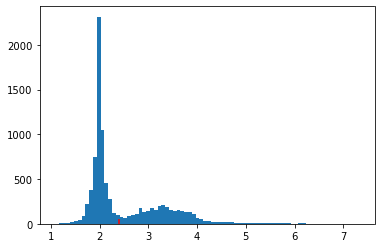

In [11]:
plt.rcParams["figure.figsize"] = (6,4)
plt.hist(absolute_ploidy, bins=80)
plt.vlines([2.4], color='r', ymin=0, ymax=50)
plt.savefig('../figures/ploidy_cutoff_selection.pdf')
plt.show()

In [12]:
absolute_ploidy_y.sum()/absolute_ploidy_y.count()

dichtomized_ploidy    0.355367
dtype: float64

In [13]:
tumor_order = list(tumor.join(absolute_ploidy).groupby('tumor').median().sort_values('ploidy', ascending=False).index)

In [14]:
coloring = (tumor.join(absolute_ploidy).groupby('tumor').median().sort_values('ploidy', ascending=False) > 2.5)

In [15]:
coloring['color'] = coloring['ploidy'].apply(lambda x: 'aquamarine' if x else 'whitesmoke')

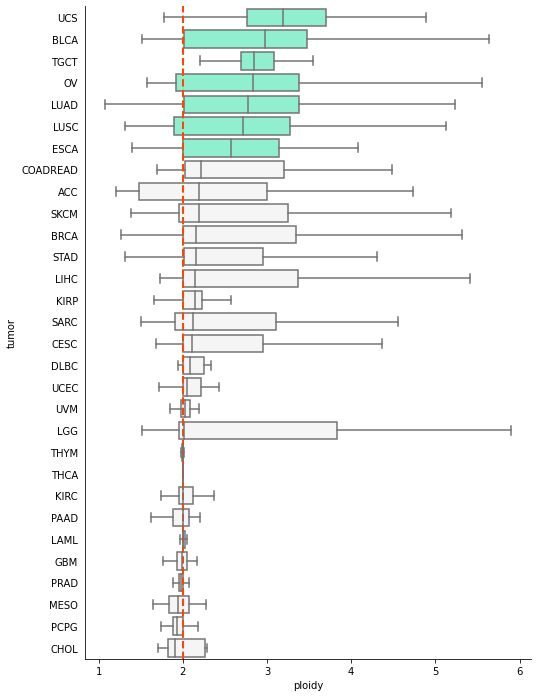

In [16]:
df = tumor.join(absolute_ploidy)
df['tumor'] = [x.upper() for x in list(df['tumor'].values)]
df['coloring'] = coloring['ploidy']
tumor_order = list(df.groupby('tumor').median().sort_values('ploidy', ascending=False).index)
plt.rcParams["figure.figsize"] = (8,12)
sns.boxplot(data=df, x='ploidy', y='tumor', order=tumor_order, color='w', palette=coloring['color'], showfliers=False)
plt.axvline(2, color='orangered', linestyle='--', linewidth=2)
plt.tick_params(axis='y', which='both',  left=False, top=False, labelleft=True)
sns.despine()
plt.savefig('../figures/ploidy_by_tumortype.pdf')

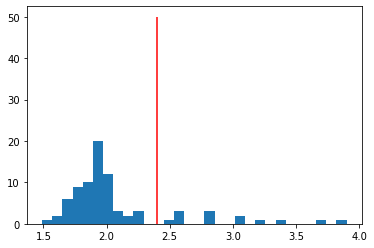

In [17]:
plt.rcParams["figure.figsize"] = (6,4)
plt.hist(df[df['tumor'] == 'MESO']['ploidy'], bins=30)
plt.vlines([2.4], color='r', ymin=0, ymax=50)
# plt.savefig('../figures/ploidy_cutoff_selection.pdf')
plt.show()

In [18]:
# heterogeneity = pd.read_csv('/mnt/disks/pancan/data/heterogeneity.tsv', delimiter=' ')
# heterogeneity

## Select genes

In [20]:
rna = rna.dropna(axis=1)

In [21]:
pca = PCA(n_components=50)
pca.fit(rna.values)

PCA(n_components=50)

In [22]:
pca_loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_), index=rna.columns)

In [23]:
genes_pca = abs(pca_loadings).sum(axis=1).nlargest(1000)

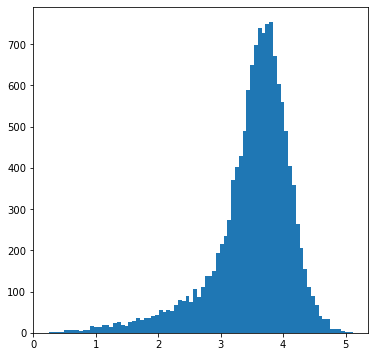

In [24]:
plt.rcParams["figure.figsize"] = (6,6)
plt.hist(abs(pca_loadings).sum(axis=1), bins=80)
plt.show()

## Run pnet

In [ ]:
# from sklearn.model_selection import StratifiedKFold

# ploidy_inds = pnet_loader.get_indicies(genetic_data, absolute_ploidy_y)
# y = list(absolute_ploidy_y.loc[ploidy_inds]['dichtomized_ploidy'])
# # Assuming `y` contains the labels for your training data
# # and `prostate_inds` contains the indices of the training data
# # Make sure `y` and `prostate_inds` have the same length

# # Create an instance of StratifiedKFold with 10 splits
# skf = StratifiedKFold(n_splits=10)

# # Initialize an empty list to store the sublists of indices
# sublists = []

# # Split the indices into sublists stratified by labels
# for train_index, _ in skf.split(ploidy_inds, y):
#     sublist = [ploidy_inds[i] for i in train_index]
#     sublists.append(sublist)
    
# for i, s in enumerate(sublists):
#     s_ = [x for x in ploidy_inds if x not in s]
#     train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data, absolute_ploidy_y, train_inds=s, test_inds=s_)
#     train_dataset.save_indicies('../data/splits/skcm_ploidy/train_set_{}.csv'.format(i))
#     test_dataset.save_indicies('../data/splits/skcm_ploidy/test_set_{}.csv'.format(i))

In [ ]:
canc_genes = list(pd.read_csv('../../pnet_database/genes/cancer_genes.txt').values.reshape(-1))

In [26]:
meso_val_target = tumor.join(absolute_ploidy_y)[tumor.join(absolute_ploidy_y)['tumor'] == 'meso'][['dichtomized_ploidy']]

inds = pnet_loader.get_indicies(genetic_data = genetic_data,
                                target=meso_val_target)

meso_val_dataset = pnet_loader.PnetDataset(genetic_data = genetic_data,
                                          target=meso_val_target, indicies=inds)

Found 81 overlapping indicies
Found 13472 overlapping genes
generated input DataFrame of size (81, 13472)


In [27]:
genetic_data = {'rna': rna[rna.join(tumor)['tumor'] != 'meso']}

In [28]:
ext_val_genetic_data = {'rna': rna_ext_val, 'mut': mut_ext_val}
ext_val_ploidy = pd.read_csv('/mnt/disks/pancan/data/mel_dfci_2019/data_clinical_sample.txt',
                             delimiter='\t').set_index('Sample Identifier').iloc[4:]
ext_val_target = pd.DataFrame(ext_val_ploidy['Ploidy'].astype('float') > 2.4).astype('int')

inds = pnet_loader.get_indicies(genetic_data = ext_val_genetic_data,
                                target=ext_val_target)
ext_val_dataset = pnet_loader.PnetDataset(genetic_data = ext_val_genetic_data,
                                          target=ext_val_target, indicies=inds, gene_set=canc_genes)

Found 121 overlapping indicies


NameError: name 'canc_genes' is not defined

In [ ]:
class_weights = util.get_class_weights(torch.tensor(absolute_ploidy_y.values).view(-1))
for i in range(10):
    model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data, absolute_ploidy_y,seed=0, dropout=0.2, input_dropout=0.5, lr=1e-3,
                                                                             weight_decay=1e-3, batch_size=64, epochs=400, early_stopping=True,
                                                                             loss_weight=class_weights, save_path='../results/ploidy/model',
                                                                             loss_fn=nn.BCEWithLogitsLoss(reduce=None), gene_set=canc_genes)
    plt.clf()
    Pnet.evaluate_interpret_save(model, test_dataset, '../results/ploidy/tcga/run{}'.format(i))
    Pnet.evaluate_interpret_save(model, meso_val_dataset, '../results/ploidy/tcga_meso/run{}'.format(i))

In [ ]:
all_imps = pd.DataFrame(columns=['SNR', 'Model', 'Layer', 'imp_mean', 'imp_std'])
for l in ['gene_feature', 'gene', 'layer_0', 'layer_1', 'layer_2', 'layer_3']:
    df_imps = pd.DataFrame()
    df_ranks = pd.DataFrame()
    for i in range(10):
        imps = pd.read_csv('../results/ploidy/tcga/run{}/{}_importances.csv'.format(i, l)).set_index('Unnamed: 0')
        imps = abs(imps.join(meso_val_target).groupby('dichtomized_ploidy').mean().diff(axis=0).iloc[1])
        ranks = imps.rank(ascending=False)
        df_imps['run{}'.format(i)] = imps
        df_ranks['run{}'.format(i)] = ranks

    imp_mean = df_imps.mean(axis=1)
    imp_std = df_imps.std(axis=1)
    snr = imp_mean/(imp_std+1e-9)
    melted_imps = snr.to_frame('SNR')
    melted_imps['imp_mean'] = imp_mean
    melted_imps['imp_std'] = imp_std
    melted_imps['Model'] = 'P-Net'
    melted_imps['Layer'] = l
    all_imps = pd.concat([all_imps, melted_imps])

        
layer_numeric = {'gene_feature':-1, 'gene':0, 'layer_0':1, 'layer_1':2, 'layer_2':3, 'layer_3':4}
all_imps['Numeric Layer'] = all_imps['Layer'].apply(lambda x: layer_numeric[x])

all_imps['Z'] = all_imps.groupby('Layer')['SNR'].transform(lambda x: (x - x.mean()) / x.std())
all_imps['p_val'] = scipy.stats.norm.sf(abs(all_imps['Z']))
all_imps[all_imps['Z'] > 5]

In [ ]:
all_imps[(all_imps['Z'] > 5) & (all_imps['Layer'] == 'gene')]

Given 1 Input modalities


/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Found 9011 overlapping indicies
Initializing Train Dataset
Found 13472 overlapping genes
generated input DataFrame of size (6308, 13472)
Initializing Test Dataset
Found 13472 overlapping genes
generated input DataFrame of size (2703, 13472)
Given 1 Input modalities
Found 9011 overlapping indicies
Initializing Train Dataset
Found 13472 overlapping genes
generated input DataFrame of size (6308, 13472)
Initializing Test Dataset
Found 13472 overlapping genes
generated input DataFrame of size (2703, 13472)
Given 1 Input modalities
Found 9011 overlapping indicies
Initializing Train Dataset
Found 13472 overlapping genes
generated input DataFrame of size (6308, 13472)
Initializing Test Dataset
Found 13472 overlapping genes
generated input DataFrame of size (2703, 13472)
Given 1 Input modalities
Found 9011 overlapping indicies
Initializing Train Dataset
Found 13472 overlapping genes
generated input DataFrame of size (6308, 13472)
Initializing Test Dataset
Found 13472 overlapping genes
generated

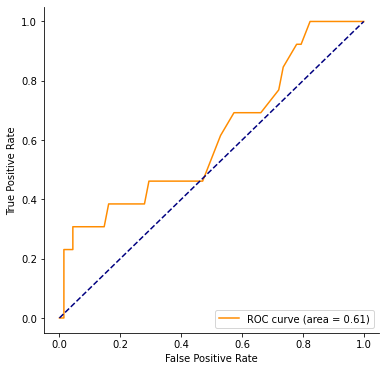

In [29]:
for i in range(10):
    path = '../results/ploidy/tcga_rf/run{}'.format(i)
    if not os.path.exists(path):
        os.makedirs(path)
    train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data, target=absolute_ploidy_y)
    
    x_train = train_dataset.x
    additional_train = train_dataset.additional
    y_train = train_dataset.y.ravel()
    x_test = test_dataset.x
    additional_test = test_dataset.additional
    y_test = test_dataset.y.ravel()
    
    rfc = RandomForestClassifier(max_depth=None, random_state=0)
    rfc.fit(x_train, y_train)
    preds = rfc.predict(x_test)
    preds_prob = rfc.predict_proba(x_test)
    plt.clf()
    auc = util.get_auc(torch.tensor(preds_prob[:,1], dtype=torch.float), y_test, save=path+'/auc_curve.pdf')
    auc_prc = util.get_auc_prc(torch.tensor(preds_prob[:,1], dtype=torch.float), y_test)
    f1_score = util.get_f1(torch.tensor(preds, dtype=torch.float), y_test)
    importances = rfc.feature_importances_
    forest_importances = pd.Series(importances, index=test_dataset.input_df.columns)
    forest_importances.to_csv(path+'/gene_feature_importances.csv')
    torch.save(auc, path+'/AUC.pt')
    torch.save(auc_prc, path+'/AUC_PRC.pt')
    torch.save(f1_score, path+'/F1.pt')
    
    # Val Data evaluation:
    path = '../results/ploidy/tcga_meso_rf/run{}'.format(i)
    if not os.path.exists(path):
        os.makedirs(path)
    x_val = meso_val_dataset.x
    additional_val = meso_val_dataset.additional
    y_val = meso_val_dataset.y.ravel()

    preds = rfc.predict(x_val)
    preds_prob = rfc.predict_proba(x_val)
    plt.clf()
    auc = util.get_auc(torch.tensor(preds_prob[:,1], dtype=torch.float), y_val, save=path+'/auc_curve.pdf')
    auc_prc = util.get_auc_prc(torch.tensor(preds_prob[:,1], dtype=torch.float), y_val)
    f1_score = util.get_f1(torch.tensor(preds, dtype=torch.float), y_val)
    importances = rfc.feature_importances_
    forest_importances = pd.Series(importances, index=meso_val_dataset.input_df.columns)
    forest_importances.to_csv(path+'/gene_feature_importances.csv')
    torch.save(auc, path+'/AUC.pt')
    torch.save(auc_prc, path+'/AUC_PRC.pt')
    torch.save(f1_score, path+'/F1.pt')

In [ ]:
num_sections = 1
rf_imps = pd.DataFrame()
rf_ranks = pd.DataFrame()
for i in range(10):
    imps = pd.read_csv('../results/ploidy/tcga_rf/run{}/gene_feature_importances.csv'.format(i)).set_index('Unnamed: 0')
    ranks = imps.rank(ascending=False)
    rf_imps['run{}'.format(i)] = imps
    rf_ranks['run{}'.format(i)] = ranks
    
imp_mean = rf_imps.mean(axis=1)
imp_std = rf_imps.std(axis=1)
snr = imp_mean/(imp_std+1e-9)
# melted_imps = snr.to_frame('SNR')
# melted_imps['imp_mean'] = imp_mean
# melted_imps['imp_std'] = imp_std
# melted_imps['Model'] = 'P-Net'
# melted_imps['Layer'] = l
# all_imps = pd.concat([all_imps, melted_imps])
    
# rf_imps.mean(axis=1).nlargest(10)

# rf_imps['Z'] = rf_imps.groupby('Layer')['SNR'].transform(lambda x: (x - x.mean()) / x.std())
# all_imps['p_val'] = scipy.stats.norm.sf(abs(all_imps['Z']))
# all_imps[all_imps['Z'] > 5]
z = (snr - snr.mean()) / snr.std()
p_val = scipy.stats.norm.sf(abs(z))
z[z > 5]

In [ ]:
z.nlargest(10)

In [34]:
data_sets = ['tcga_rf', 'tcga_meso_rf']
listl = []
for ds in data_sets:
    for i in range(10):
        auc = torch.load('../results/ploidy/{}/run{}/AUC.pt'.format(ds, i))
        rf = ds.split('_')[-1]
        ds_ = ds
        if rf == 'rf':
            listl.append([auc.item(), ds_, 'RF'])
        else:
            listl.append([auc.item(), ds_, 'P-Net'])

auc_df = pd.DataFrame(listl, columns=['AUC', 'Data Set', 'Model'])
auc_df['Data Set'] = auc_df['Data Set'].apply(lambda x: x.upper())

In [35]:
auc_df.groupby(['Data Set', 'Model']).mean()

,,AUC
Data Set,Model,
TCGA_MESO_RF,RF,0.669457
TCGA_RF,RF,0.823176


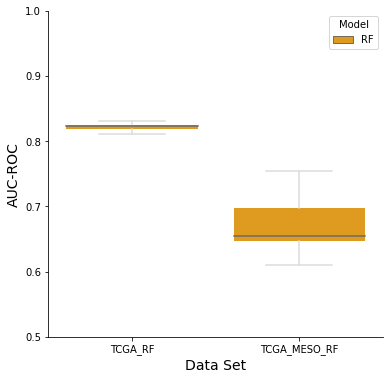

In [36]:
custom_colors = {'P-Net': '#41B6E6', 'RF': '#FFA300'}
sns.boxplot(data=auc_df, y='AUC', x='Data Set', hue='Model', showfliers=False, palette=custom_colors,
                      whiskerprops={'color': 'gainsboro'},
                      capprops={'color': 'gainsboro'},
                        boxprops={'edgecolor': 'none'},
                      medianprops={'color': 'dimgrey'})
ax = plt.gca()

ax.spines[['top', 'right']].set_visible(False)
ax.set_ylabel('AUC-ROC', size=14)
ax.set_xlabel('Data Set', size=14)
ax.set_ylim((0.5,1))
#plt.savefig('../figures/SKCM_ploidy_TCGA_vs_Liu.pdf')
plt.show()

In [ ]:
imps_dir = '/mnt/disks/pancan/pnet/results/ploidy/tcga_skcm/'
savepath = '/mnt/disks/pancan/pnet/figures/skcm_ploidy_sankey_diagram.html'
sk = sankey_diag.SankeyDiag(imps_dir, runs=10)
fig = sk.get_sankey_diag(savepath)

In [ ]:
absolute_ploidy_y

In [ ]:
all_imps = {}
for m in ['tcga_skcm']:
    for l in ['gene_feature', 'gene', 'layer_0', 'layer_1', 'layer_2', 'layer_3', 'layer_4']:
        df_imps = pd.DataFrame()
        for i in range(10):
            imps = pd.read_csv('../results/ploidy/{}/run{}/{}_importances.csv'.format(m, i, l)).set_index('Unnamed: 0')
            imps = abs(imps.join(absolute_ploidy_y).groupby('dichtomized_ploidy').mean().diff(axis=0).iloc[1])
            df_imps['run{}_{}'.format(i, l)] = imps
        all_imps[l] = df_imps
        all_imps[l] = (all_imps[l]-all_imps[l].mean())/all_imps[l].std()

In [ ]:
for k in all_imps:
    column_means = all_imps[k].T.mean()
    sorted_columns = column_means.sort_values(ascending=False)
    top_10_columns = sorted_columns[:10].index
    top_columns_df = all_imps[k].T[top_10_columns[::-1]]
    top_columns_df.boxplot(vert=False, showfliers=False)
    plt.xlabel('Mean Importance')
    sns.despine()
    plt.grid(False)
    plt.show()

In [ ]:
pnet_imps = pd.DataFrame()
pnet_ranks = pd.DataFrame()
for i in range(10):
    imps = pd.read_csv('../results/ploidy/liu_val_skcm/run{}/gene_importances.csv'.format(i)).set_index('Unnamed: 0')
    imps = abs(imps.join(ext_val_target).groupby('Ploidy').mean().diff(axis=0).iloc[1])
    ranks = imps.rank(ascending=False)
    pnet_imps['run{}'.format(i)] = imps
    pnet_ranks['run{}'.format(i)] = ranks
    
pnet_imps = (pnet_imps-pnet_imps.mean())/pnet_imps.std()

In [ ]:
num_sections = 2
rf_imps = pd.DataFrame()
rf_ranks = pd.DataFrame()
for i in range(10):
    imps = pd.read_csv('../results/ploidy/liu_val_skcm_rf/run{}/gene_feature_importances.csv'.format(i)).set_index('Unnamed: 0')
    section_size = len(imps) // num_sections
    dfs = [imps[i * section_size : (i + 1) * section_size] for i in range(num_sections)]
    for df in dfs:
        df.index = [ind.split('_')[0] for ind in dfs[1].index]
    imps = dfs[0] + dfs[1]
    ranks = imps.rank(ascending=False)
    rf_imps['run{}'.format(i)] = imps
    rf_ranks['run{}'.format(i)] = ranks
    
rf_imps = (rf_imps-rf_imps.mean())/rf_imps.std()

In [ ]:
data = {'rf_imps': rf_imps.mean(axis=1), 'pnet_imps': pnet_imps.mean(axis=1)}
df = pd.DataFrame(data)

y_threshold = 2
x_threshold = 2

plt.scatter(df['rf_imps'], df['pnet_imps'], s=1000/(1+pnet_ranks.std(axis=1)).values, alpha=0.3, color='#00629B')

for index, row in df.iterrows():
    if row['pnet_imps'] > y_threshold and row['rf_imps'] > x_threshold:
        plt.annotate(index, (row['rf_imps'], row['pnet_imps']),
                     textcoords="offset points", xytext=(0, 10), ha='center')
    if row['pnet_imps'] > 3.5 or row['rf_imps'] > 3.5:
        plt.annotate(index, (row['rf_imps'], row['pnet_imps']),
                     textcoords="offset points", xytext=(0, 10), ha='center')
        
    if index == 'TP53' or index == 'PTEN':
        plt.annotate(index, (row['rf_imps'], row['pnet_imps']),
                     textcoords="offset points", xytext=(0, 10), ha='center')
plt.xlabel('RF Importance scores', size=14)
plt.ylabel('P-Net Importance scores', size=14)       
sns.despine()
plt.savefig('../figures/SKCM_ploidy_LIU_imp_genes_scatter.pdf')


In [ ]:
all_imps = {}
for m in ['tcga_skcm']:
    for l in ['gene_feature', 'gene', 'layer_0', 'layer_1', 'layer_2', 'layer_3', 'layer_4']:
        df_imps = pd.DataFrame()
        for i in range(10):
            imps = pd.read_csv('../results/ploidy/{}/run{}/{}_importances.csv'.format(m, i, l)).set_index('Unnamed: 0')
            imps = abs(imps.join(absolute_ploidy_y).groupby('dichtomized_ploidy').mean().diff(axis=0).iloc[1])
            df_imps['run{}_{}'.format(i, l)] = imps
        all_imps[l] = df_imps
        all_imps[l] = (all_imps[l]-all_imps[l].mean())/all_imps[l].std()

In [ ]:
for k in all_imps:
    column_means = all_imps[k].T.mean()
    sorted_columns = column_means.sort_values(ascending=False)
    top_10_columns = sorted_columns[:10].index
    top_columns_df = all_imps[k].T[top_10_columns[::-1]]
    top_columns_df.boxplot(vert=False, showfliers=False)
    plt.xlabel('Mean Importance')
    sns.despine()
    plt.grid(False)
    plt.show()

In [ ]:
import gseapy as gp

In [ ]:
from gmt_reader import GMT

In [ ]:
reactome_gmt = GMT()

In [ ]:
reactome_pathways = reactome_gmt.load_data(filename='/mnt/disks/pancan/data/reactome/ReactomePathways.gmt', )

In [ ]:
layer_pathways = list(all_imps['layer_4'].index)
filtered_df = reactome_pathways[reactome_pathways['group'].isin(layer_pathways)]
grouped_dict = filtered_df.groupby('group')['gene'].apply(list).to_dict()

In [ ]:
reactome_gmt.write_dict_to_file(grouped_dict, '/mnt/disks/pancan/data/reactome/ReactomePathways_l4.gmt')

In [ ]:
rf_imps

In [ ]:
rf_all_imps = {}
for i in range(5):
    rf_layer_imps = pd.DataFrame()
    for j in range(10):
        pre_res = gp.prerank(rnk=rf_imps['run{}'.format(j)], # or rnk = rnk,
                         gene_sets='/mnt/disks/pancan/data/reactome/ReactomePathways_l{}.gmt'.format(i),
                         threads=4,
                         min_size=5,
                         max_size=1000,
                         permutation_num=1000, # reduce number to speed up testing
                         outdir=None, # don't write to disk
                         seed=6,
                         verbose=False, # see what's going on behind the scenes
                        )
        pre_res = pd.DataFrame(pre_res.res2d.set_index('Term')['NES'])
        rf_layer_imps['run{}'.format(j)] = pre_res
    rf_all_imps['layer_{}'.format(i)] = rf_layer_imps

In [ ]:
rf_all_imps['layer_0']

In [ ]:
data = {'rf_imps': rf_all_imps['layer_4'].mean(axis=1), 'pnet_imps': all_imps['layer_4'].mean(axis=1)}
df = pd.DataFrame(data)

y_threshold = 1
x_threshold = 0.5

plt.scatter(df['rf_imps'], df['pnet_imps'], alpha=0.3, color='#00629B')

for index, row in df.iterrows():
    if row['pnet_imps'] > y_threshold and row['rf_imps'] > x_threshold:
        plt.annotate(index, (row['rf_imps'], row['pnet_imps']),
                     textcoords="offset points", xytext=(0, 10), ha='center')
    if row['pnet_imps'] > 1.5 or row['rf_imps'] > 1.2:
        plt.annotate(index, (row['rf_imps'], row['pnet_imps']),
                     textcoords="offset points", xytext=(0, 10), ha='center')
        
    if index == 'TP53' or index == 'PTEN':
        plt.annotate(index, (row['rf_imps'], row['pnet_imps']),
                     textcoords="offset points", xytext=(0, 10), ha='center')
plt.xlabel('RF Importance scores', size=14)
plt.ylabel('P-Net Importance scores', size=14)       
sns.despine()
plt.savefig('../figures/SKCM_ploidy_LIU_imp_layer_4_scatter.pdf')


### Hallmark Gene set predictions

In [ ]:
class_weights = util.get_class_weights(torch.tensor(absolute_ploidy_y.values).view(-1))
for i in range(10):
    train_inds = list(pd.read_csv('../data/splits/skcm_ploidy/train_set_{}.csv'.format(i))['indicies'])
    test_inds = list(pd.read_csv('../data/splits/skcm_ploidy/test_set_{}.csv'.format(i))['indicies'])
    model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run_geneset(genetic_data, absolute_ploidy_y, 
                                                                                     geneset_path='/mnt/disks/pancan/pnet/data/hallmark/h.all.v2022.1.Hs.symbols.gmt',
                                                                                     seed=0, dropout=0.2, input_dropout=0.5, lr=1e-3, weight_decay=1e-3,
                                                                               batch_size=64, epochs=400, early_stopping=True, train_inds=train_inds,
                                                                               test_inds=test_inds, loss_weight=class_weights, 
                                                                                     save_path='../results/ploidy_hallmark/model',
                                                                             loss_fn=nn.BCEWithLogitsLoss(reduce=None), genes=canc_genes)
    plt.clf()
    Pnet.evaluate_interpret_save(model, test_dataset, '../results/ploidy_hallmark/run{}'.format(i))
    Pnet.evaluate_interpret_save(model, ext_val_dataset, '../results/ploidy_hallmark/liu_val_skcm/run{}'.format(i))

In [ ]:
data_sets = ['', '/liu_val_skcm']
listl = []
for ds in data_sets:
    for i in range(10):
        auc = torch.load('../results/ploidy_hallmark{}/run{}/AUC.pt'.format(ds, i))
        if ds == '':
            listl.append([auc.item(), 'liu', 'Hallmark-Net'])
        else:
            listl.append([auc.item(), 'tcga', 'Hallmark-Net'])

auc_df_ = pd.DataFrame(listl, columns=['AUC', 'Data Set', 'Model'])
auc_df_['Data Set'] = auc_df_['Data Set'].apply(lambda x: x.upper() if x=='tcga' else x.upper()+' 2019')
auc_df = pd.concat([auc_df, auc_df_])

In [ ]:
auc_df.groupby(['Data Set', 'Model']).mean()

In [ ]:
custom_colors = {'P-Net': '#41B6E6', 'RF': '#FFA300', 'Hallmark-Net': '#00629B'}
sns.boxplot(data=auc_df, y='AUC', x='Data Set', hue='Model', showfliers=False, palette=custom_colors,
                      whiskerprops={'color': 'gainsboro'},
                      capprops={'color': 'gainsboro'},
                        boxprops={'edgecolor': 'none'},
                      medianprops={'color': 'dimgrey'})
ax = plt.gca()

ax.spines[['top', 'right']].set_visible(False)
ax.set_ylabel('AUC-ROC', size=14)
ax.set_xlabel('Data Set', size=14)
ax.set_ylim((0.5,1))
plt.savefig('../figures/SKCM_ploidy_TCGA_vs_Liu.pdf')
plt.show()

In [ ]:
hallmark_imps = pd.DataFrame()
hallmark_ranks = pd.DataFrame()
for i in range(10):
    imps = pd.read_csv('../results/ploidy_hallmark/liu_val_skcm/run{}/gene_importances.csv'.format(i)).set_index('Unnamed: 0')
    imps = abs(imps.join(ext_val_target).groupby('Ploidy').mean().diff(axis=0).iloc[1])
    ranks = imps.rank(ascending=False)
    hallmark_imps['run{}'.format(i)] = imps
    hallmark_ranks['run{}'.format(i)] = ranks
    
hallmark_imps = (hallmark_imps-hallmark_imps.mean())/hallmark_imps.std()

In [ ]:
data = {'hallmark_imps': hallmark_imps.mean(axis=1), 'pnet_imps': pnet_imps.mean(axis=1)}
df = pd.DataFrame(data)

y_threshold = 2
x_threshold = 2

plt.scatter(df['hallmark_imps'], df['pnet_imps'], s=1000/(1+pnet_ranks.std(axis=1)).values, alpha=0.3, color='#00629B')

for index, row in df.iterrows():
    if row['pnet_imps'] > y_threshold and row['hallmark_imps'] > x_threshold:
        plt.annotate(index, (row['hallmark_imps'], row['pnet_imps']),
                     textcoords="offset points", xytext=(0, 10), ha='center')
    if row['pnet_imps'] > 3.5 or row['hallmark_imps'] > 3.5:
        plt.annotate(index, (row['hallmark_imps'], row['pnet_imps']),
                     textcoords="offset points", xytext=(0, 10), ha='center')
        
    if index == 'TP53' or index == 'PTEN':
        plt.annotate(index, (row['hallmark_imps'], row['pnet_imps']),
                     textcoords="offset points", xytext=(0, 10), ha='center')
plt.xlabel('Hallmark Importance scores', size=14)
plt.ylabel('P-Net Importance scores', size=14)       
sns.despine()
plt.savefig('../figures/SKCM_ploidy_LIU_imp_genes_scatter_hallmark.pdf')


In [ ]:
all_hallmark_imps = {}
for m in ['']:
    for l in ['gene_feature', 'gene', 'layer_0', 'layer_1', 'layer_2']:
        df_imps = pd.DataFrame()
        for i in range(10):
            imps = pd.read_csv('../results/ploidy_hallmark/liu_val_skcm/run{}/{}_importances.csv'.format(i, l)).set_index('Unnamed: 0')
            imps = abs(imps.join(ext_val_target).groupby('Ploidy').mean().diff(axis=0).iloc[1])
            df_imps['run{}_{}'.format(i, l)] = imps
        all_hallmark_imps[l] = df_imps
        all_hallmark_imps[l] = (all_hallmark_imps[l]-all_hallmark_imps[l].mean())/all_hallmark_imps[l].std()

In [ ]:
rf_layer_imps = pd.DataFrame()
for j in range(10):
    pre_res = gp.prerank(rnk=rf_imps['run{}'.format(j)], # or rnk = rnk,
                     gene_sets='/mnt/disks/pancan/data/hallmark/h.all.v2022.1.Hs.symbols.gmt',
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=False, # see what's going on behind the scenes
                    )
    pre_res = pd.DataFrame(pre_res.res2d.set_index('Term')['NES'])
    rf_layer_imps['run{}'.format(j)] = pre_res
rf_all_imps['layer_hallmark'.format(i)] = rf_layer_imps

In [ ]:
data = {'rf_imps': rf_all_imps['layer_hallmark'].mean(axis=1), 'hallmark_imps': all_hallmark_imps['layer_0'].mean(axis=1)}
df = pd.DataFrame(data)

y_threshold = 0.3
x_threshold = 0.5

plt.scatter(df['rf_imps'], df['hallmark_imps'], alpha=0.3, color='#00629B')

for index, row in df.iterrows():
    if row['hallmark_imps'] > y_threshold and row['rf_imps'] > x_threshold:
        plt.annotate(index, (row['rf_imps'], row['hallmark_imps']),
                     textcoords="offset points", xytext=(0, 10), ha='center')
    if row['hallmark_imps'] > 0.5 or row['rf_imps'] > 1:
        plt.annotate(index, (row['rf_imps'], row['hallmark_imps']),
                     textcoords="offset points", xytext=(0, 10), ha='center')
        
    if index == 'TP53' or index == 'PTEN':
        plt.annotate(index, (row['rf_imps'], row['hallmark_imps']),
                     textcoords="offset points", xytext=(0, 10), ha='center')
plt.xlabel('RF Importance scores', size=14)
plt.ylabel('Hallmark-Net Importance scores', size=14)       
sns.despine()
plt.savefig('../figures/SKCM_ploidy_LIU_imp_layer_0_hallmark_scatter.pdf')


## Leave one (cancer type) out training

In [ ]:
cancer_types = tumor['tumor'].unique()

In [ ]:
leave_one_out_auc = {}
for cancer in cancer_types:
    test_inds = list(tumor[tumor['tumor'] == cancer].index)
    model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data,
                                                                         absolute_ploidy_y,
                                                                         verbose=True,
                                                                         early_stopping=True,
                                                                            test_inds=test_inds)
    x_test = test_dataset.x
    additional_test = test_dataset.additional
    y_test = test_dataset.y
    model.to('cpu')

    pred = model(x_test, additional_test).detach()
    auc = util.get_auc(pred, y_test)
    leave_one_out_auc[cancer] = auc

In [ ]:
leave_one_out_auc = pd.DataFrame.from_dict(leave_one_out_auc, orient='index')
leave_one_out_auc.columns = ['AUC']
leave_one_out_auc['AUC'] = leave_one_out_auc['AUC'].astype(float)
leave_one_out_auc.index.names = ['tumor']

tvc = pd.DataFrame(tumor.value_counts(), columns=['samples']).reset_index()
tvc = tvc.set_index('tumor')


df = tumor.join(absolute_ploidy)
tmp = df.groupby('tumor').mean()

leave_one_out_auc = leave_one_out_auc.join(tmp, how='inner')
leave_one_out_auc = leave_one_out_auc.join(tvc, how='inner')

In [ ]:
leave_one_out_auc.sort_values('AUC').plot.barh(y='AUC')
plt.xlabel('Leave-one-out-AUC')
plt.axvline(0.5, color='orangered', linestyle='--', linewidth=2)
plt.show()

In [ ]:
leave_one_out_auc.sort_values('ploidy').plot.barh(y='AUC')
plt.xlabel('Leave-one-out-AUC')
plt.axvline(0.5, color='orangered', linestyle='--', linewidth=2)
plt.show()

In [ ]:
leave_one_out_auc.sort_values('samples').plot.barh(y='AUC')
plt.xlabel('Leave-one-out-AUC')
plt.axvline(0.5, color='orangered', linestyle='--', linewidth=2)
plt.show()

In [ ]:
feature_importances, additional_importances = model.integrated_gradients(test_dataset)

In [ ]:
feature_importances.sum().nlargest(20)

In [ ]:
layerwise_imps = model.layerwise_importance(test_dataset)

In [ ]:
for l in layerwise_imps:
    print(l.nlargest(5))

In [ ]:
sns.histplot(data=rna.join(absolute_ploidy_y), x='POC5', hue='dichtomized_ploidy',bins=80,
             stat='density', kde=True, common_norm=False)

In [ ]:
gene_order = high_ploidy_importances.median().sort_values(ascending=True).index
gene_order

In [ ]:
high_ploidy_importances = gene_importances[gene_importances.join(absolute_ploidy_y)['dichtomized_ploidy'] == 1]

In [ ]:
plt.rcParams["figure.figsize"] = (6,8)
high_ploidy_importances[list(gene_order[-20:])].plot(kind='box', vert=False, showfliers=False)
plt.savefig('../figures/genes_ploidy.pdf')
plt.show()

In [ ]:
pathway_importances = model.layerwise_importance(test_dataset)

In [ ]:
for l in pathway_importances:
    print(l.nlargest(5))

In [ ]:
some_genes = ['CBFA2T2', 'DNMT3B', 'MYL9', 'POLR2K', 'RPS27A']
fig, axs = plt.subplots(1, 5, figsize=((15, 5)))
for i, gene in enumerate(some_genes):
    gene = gene.split('_')[0]
    sns.boxplot(data=cna.join(absolute_ploidy), x=gene, y='ploidy', ax=axs[i], showfliers=False)
plt.savefig('../figures/cna_vs_ploiy_top_genes.pdf')
plt.show()

In [ ]:
pred = torch.sigmoid(model(x_test, additional_test))

In [ ]:
pred_ = pd.DataFrame(pred.detach().numpy(), index=test_dataset.input_df.index, columns=['prediction'])

In [ ]:
pred_.join(tumor)

In [ ]:
df['tumor'].values[0].upper()

In [ ]:
df = pred_.join(tumor)
df['tumor'] = [str(x).upper() for x in df['tumor'].values]
tumor_order = list(df.groupby('tumor').median().sort_values('prediction', ascending=False).index)
plt.rcParams["figure.figsize"] = (8,12)
sns.boxplot(df, x='prediction', y='tumor', order=tumor_order, color='w', showfliers=False)
plt.axvline(0.5, color='orangered', linestyle='--', linewidth=2)
plt.tick_params(axis='y', which='both',  left=False, top=False, labelleft=True)
sns.despine()
plt.savefig('../figures/prediction_by_tumortype.pdf')

In [ ]:
missclass_df.groupby('tumor').mean()

In [ ]:
plt.rcParams["figure.figsize"] = (6,6)
missclass_df = pred_.join(tumor).join(test_dataset.target)
missclass_df['misclass'] = missclass_df.apply(lambda x: 1-int(round(x['prediction'])==x['dichtomized_ploidy']), axis=1)
sns.scatterplot(missclass_df.groupby('tumor').mean(), x='dichtomized_ploidy', y='misclass')
for tum in missclass_df.groupby('tumor').mean().index:
    plt.annotate(missclass_df.groupby('tumor').mean().loc[tum].name,
                (missclass_df.groupby('tumor').mean().loc[tum]['dichtomized_ploidy'],
                 missclass_df.groupby('tumor').mean().loc[tum]['misclass']))
plt.savefig('../figures/ploidy_vs_misclass_by_tumortype.pdf')

## Ploidy by cancer type training

In [ ]:
ploidy_range = absolute_ploidy_y.join(tumor).groupby('tumor').mean()['dichtomized_ploidy'].between(0.35,0.65)
cancer_types = tumor['tumor'].unique()
cancer_types = [ct for ct in cancer_types if ploidy_range[ct]]
training_cancer_types = [x for x in cancer_types if (tumor['tumor'].value_counts() > 200)[x]]

df = pd.DataFrame()
df['WGD'] = tumor.join(absolute_ploidy_y).groupby('tumor').sum()['dichtomized_ploidy']
df['DP'] = tumor.join(absolute_ploidy_y).groupby('tumor').count()['dichtomized_ploidy'] - df['WGD']
min_samples = df.loc[training_cancer_types].min().min()

In [ ]:
def stratified_inds(tumor_inds, target, samples_nbr):
    target = target.loc[set(tumor_inds).intersection(target.index)]
    pos_samples = list(target[target[target.columns[0]] == 1].index)
    neg_samples = list(target[target[target.columns[0]] == 0].index)
    random.shuffle(pos_samples)
    random.shuffle(neg_samples)
    train_inds = pos_samples[:samples_nbr] + neg_samples[:samples_nbr]
    test_inds = pos_samples[samples_nbr:] + neg_samples[samples_nbr:]
    return train_inds, test_inds

In [ ]:
canc_spec_auc = {}
for train_cancer in training_cancer_types:
    inds = list(tumor[tumor['tumor'] == train_cancer].index)
    train_inds, test_inds = stratified_inds(inds, absolute_ploidy_y, 100)
    model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data,
                                                                         absolute_ploidy_y,
                                                                         verbose=False,
                                                                         early_stopping=True,
                                                                                 train_inds=train_inds,
                                                                        test_inds=test_inds)
    val_aucs = []
    for val_cancer in cancer_types:
        print(val_cancer)
        val_inds = list(tumor[tumor['tumor'] == val_cancer].index)
        val_inds = set(val_inds).intersection(pnet_loader.get_indicies(genetic_data, absolute_ploidy_y))
        val_dataset = pnet_loader.PnetDataset(genetic_data, absolute_ploidy_y, val_inds,
                                              additional_data=None, gene_set=None)
        x_val = val_dataset.x
        additional_val = val_dataset.additional
        y_val = val_dataset.y
        model.to('cpu')

        pred = model(x_val, additional_val).detach()
        auc = util.get_auc(pred, y_val)
        val_aucs.append(auc)
    canc_spec_auc[train_cancer] = val_aucs

In [ ]:
cancer_spec_auc_df = pd.DataFrame(canc_spec_auc, index=cancer_types).astype(float)
cancer_spec_auc_df.columns = list([x+'_train' for x in canc_spec_auc.keys()])
cancer_spec_auc_df.to_csv('/mnt/disks/pancan/pnet/results/ploidy/cancer_spec_ploidy_auc.csv')

In [ ]:
sns.clustermap(cancer_spec_auc_df.T, vmin=0, vmax=1, method='ward')

##### Multiple runs

In [ ]:
def fold_run(x, y, n):
    aucs = []
    most_imp_genes = []
    for r in range(n):
        print('run: {}'.format(r))
        model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(x,
                                                                             y,
                                                                             verbose=False,
                                                                             early_stopping=True)

        x_train = train_dataset.input_df.astype(float).values
        additional_train = train_dataset.additional_data.astype(float).values
        y_train = train_dataset.target.astype(float).values.reshape(-1)
        x_test = test_dataset.input_df.astype(float).values
        additional_test = test_dataset.additional_data.astype(float).values
        y_test = test_dataset.target.astype(float).values.reshape(-1)

        pred = model(torch.tensor(x_test, dtype=torch.float),
                                  torch.tensor(additional_test, dtype=torch.float)
                    )
        y_pred_proba = pred.detach().numpy().squeeze()
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
        test_auc = metrics.roc_auc_score(y_test, pred.detach().numpy().squeeze())

        aucs.append(test_auc)

        gene_importances, additional_importances = model.deepLIFT(test_dataset)
        most_imp_genes.append(gene_importances.sum())
    return aucs, most_imp_genes

In [ ]:
def fold_run_rf(x, y, n):
    aucs = []
    most_imp_genes = []
    for r in range(n):
        print('run: {}'.format(r))
        train_dataset, test_dataset = pnet_loader.generate_train_test(x, y, None, None, 0.3, None)
        clf = RandomForestClassifier()
        clf.fit(train_dataset.input_df.values, train_dataset.target.values.reshape(-1))
        
        x_train = train_dataset.input_df.astype(float).values
        additional_train = train_dataset.additional_data.astype(float).values
        y_train = train_dataset.target.astype(float).values.reshape(-1)
        x_test = test_dataset.input_df.astype(float).values
        additional_test = test_dataset.additional_data.astype(float).values
        y_test = test_dataset.target.astype(float).values.reshape(-1)

        y_pred_proba = clf.predict_proba(x_test)
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba[:,1])
        test_auc = metrics.roc_auc_score(y_test, y_pred_proba[:,1])

        aucs.append(test_auc)

        gene_importances = clf.feature_importances_
        most_imp_genes.append(pd.DataFrame(clf.feature_importances_, index=test_dataset.input_df.columns))
    return aucs, most_imp_genes

In [ ]:
ploidy_absolut_auc, ploidy_absolut_genes = fold_run(genetic_data, absolute_ploidy_y, 10)
ploidy_absolut_auc_rf, ploidy_absolut_genes_rf = fold_run_rf(genetic_data, absolute_ploidy_y, 10)

In [ ]:
data_pnet = [ploidy_absolut_auc]
data_rf = [ploidy_absolut_auc_rf]

ticks = ['ploidy \n by absolut']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
    
    
bpl = plt.boxplot(data_pnet, positions=np.array(range(len(data_pnet)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(data_rf, positions=np.array(range(len(data_pnet)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

plt.plot([], c='#D7191C', label='pnet')
plt.plot([], c='#2C7BB6', label='rf')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.tight_layout()
plt.savefig('absolute_ploidy_auc_pnet_vs_rf.pdf')

In [ ]:
ploidy_absolut_genes

In [ ]:
ploidy_absolut_genes_rf

In [ ]:
gene_order = pd.DataFrame(ploidy_absolut_genes).mean().sort_values(ascending=False).index
df_sum = pd.DataFrame(ploidy_absolut_genes)

In [ ]:
gene_order_rf = pd.DataFrame([x[0] for x in ploidy_absolut_genes_rf]).mean().sort_values(ascending=False).index
df_sum_rf = pd.DataFrame([x[0] for x in ploidy_absolut_genes_rf])

In [ ]:
plt.rcParams["figure.figsize"] = (6,8)
df_sum[list(gene_order[:20]) + list(gene_order[-20:])].plot(kind='box', vert=False)
plt.savefig('Ploidy_important_genes.pdf')
plt.show()

In [ ]:
def check_annotate(x, y):
    if y > 1e-3/(x)**1.9 + 1e-3:
        return True
    else:
        return False

In [ ]:
import scipy.stats as ss

In [ ]:
comb_df['pnet_rank'] = ss.rankdata(comb_df['pnet_imp'])
comb_df['rf_rank'] = ss.rankdata(comb_df['rf_imp'])

In [ ]:
comb_df = pd.DataFrame([df_sum.mean(), df_sum_rf.mean()]).T
comb_df.columns = ['pnet_imp', 'rf_imp']
comb_df['pnet_rank'] = len(comb_df['pnet_imp']) - ss.rankdata(abs(comb_df['pnet_imp']))
comb_df['rf_rank'] = len(comb_df['rf_imp']) - ss.rankdata(abs(comb_df['rf_imp']))
comb_df['annotate'] = comb_df.apply(lambda x: x['pnet_rank'] + x['rf_rank'] < 100, axis=1)

In [ ]:
fig, ax = plt.subplots()

ax.scatter(comb_df['pnet_imp'], comb_df['rf_imp'], s=10)

for i in range(len(comb_df)):
    if comb_df.iloc[i]['annotate']:
        ax.annotate(comb_df.iloc[i].name, (comb_df.iloc[i]['pnet_imp'], comb_df.iloc[i]['rf_imp']))

plt.ylabel('rf importance')
plt.xlabel('pnet importance')
plt.title('Ploidy classification gene importance')
plt.savefig('important_genes_ploidy_scatter.pdf')
plt.show()

In [ ]:
import gseapy as gp

In [ ]:
def prerank_gsea(gene_importances, gene_list):
    gene_sets='../data/reactome/ReactomePathways.gmt'
    gene_importance_scores = pd.DataFrame(index=gene_list)
    gene_importance_scores['1'] = gene_importances.values.reshape((2,-1)).sum(axis=0)
        
    pre_res = gp.prerank(rnk=gene_importance_scores,
                         gene_sets = gene_sets,
                         threads=8,
                         min_size=5,
                         max_size=1000,
                         permutation_num=1000,
                         outdir='../prerank_gsea',
                         seed=6,
                         verbose=True
                        )
    return pre_res

In [ ]:
pre_res_rf = prerank_gsea(comb_df['rf_imp'], list(comb_df.iloc[:int(comb_df.shape[0]/2)].index))

In [ ]:
top_hits_rf = list(pre_res_rf.res2d.sort_values('NOM p-val').head(15)['Term'])

In [ ]:
top_hits_rf

In [ ]:
pre_res_pnet = prerank_gsea(comb_df['pnet_imp'], list(comb_df.iloc[:int(comb_df.shape[0]/2)].index))

In [ ]:
top_hits_pnet = list(pre_res_pnet.res2d.sort_values('NOM p-val').head(15)['Term'])

In [ ]:
top_hits_pnet